<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

#AUTHORS

Sam Minors 

Javier Roset Cardona 

Chunfeng Wang

# Project: Linear models

## Programming project: real estate assesment evaluation

Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.

Data (*Regression_Supervised_Train.csv*) consist of a list of features plus the resulting <i>parcelvalue</i>, described in *Case_data_dictionary.xlsx* file. Each row corresponds to a particular home valuation, and <i>transactiondate</i> is the date when the property was effectively sold. Properties are defined by <i>lotid</i>, but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometime empty, your model has to deal with it.

Note that you shouldn't use <i>totaltaxvalue</i>, <i>buildvalue</i> or <i>landvalue</i>, because they are closely correlated with the final value to predict. There is a further member of the training set predictors which is not available in the test set and therefore needs removing. 

+ Using this data build a predictive model for <b>parcelvalue</b> 
+ In your analysis for faster algorithms use the MSE criterion for choosing any hyperparameters 
+ Try a first quick implementation, then try to optimize hyperparameters
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the MSE estimate on the test data once released.
+ Bonus: Try an approach to fill NA without removing features or observations, and check improvements.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. Report missing data
2. As a simplified initial version, get rid of *missing data* by:
    + Remove columns '<i>totaltaxvalue</i>', '<i>buildvalue</i>' or '<i>landvalue</i>' from the training and testing set and also '<i>mypointer</i>' from the training set
    + Removing features that have more than 40% of missing data in the training set 
    + After that, removing observations that have missing data
3. Create *dummy variables* for relevant categorical features
4. *Build* your model and test it on the same input data
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 

You may want to iterate to refine some of these steps once you get performance results in step 5.


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Parcel value prediction made
+ Accuracy of predictions for test properties is calculated (kaggle)
+ Linear Model, Ridge and LASSO have been used
+ Accuracy itself
+ Data preparation
+ Hyperparameter optimization (alphas)
+ Code is combined with neat and understandable commentary, with some titles and comments (demonstrate you have understood the methods and the outputs produced)
+ Improved methods from what we discussed in class (properly explained/justified)

#Importing libraries and loading the dataset

In [ ]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
#loading dataset
from google.colab import drive
drive.mount('/content/drive')
path_sam = ""
path_javier = "/content/drive/MyDrive/BSE/Computational Machine learning/assignments/Linear_models_project/"

Mounted at /content/drive


#Comment on train and test datasets

The train and test datasets used here are slightly different from the original. This is due to fixing part of the neighborhoodcode missing values. To do this, a code that finds the average lat and lot of each neighborhood, and then calculates the distance to each neighborhood to find the nearest one (imposing a limit of 1 km to ensure it is not doing mistakes) has been created. As this code has to compare each missing code with all the existing codes for all dataset, it is very slow. For the train dataset needs aprox 15 minutes to execute. For this reason, the code has been executed once, and the improved train and test datasets have been downloaded and then loaded into the notebook. The updated datasets will be delivered with the code.

In [ ]:
#loading train data
df =  pd.read_csv(path_javier + "train.csv", sep = ";", decimal = ".")
df = df.drop("Unnamed: 0", axis = 1)
df_train = df.copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lotid               22000 non-null  int64  
 1   logerror            1578 non-null   object 
 2   transactiondate     1578 non-null   object 
 3   aircond             12867 non-null  float64
 4   style               211 non-null    float64
 5   basement            46 non-null     float64
 6   numbath             22000 non-null  float64
 7   numbedroom          22000 non-null  int64  
 8   classbuild          15 non-null     float64
 9   qualitybuild        13059 non-null  float64
 10  decktype            633 non-null    float64
 11  finishedarea1st     5448 non-null   float64
 12  finishedarea        21942 non-null  float64
 13  perimeterarea       0 non-null      float64
 14  totalarea           57 non-null     float64
 15  finishedareaEntry   5448 non-null   float64
 16  coun

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#Cleaning the data

In [ ]:
#deleting columns with more than 40% nulls and also
#columns 'totaltaxvalue', 'buildvalue' or 'landvalue' 'mypointer'

df_train.drop(["totaltaxvalue","buildvalue","landvalue","mypointer"], inplace = True, axis = 1)

for column in df_train.columns:
  if df_train.loc[:,column].isna().sum()/len(df_train.loc[:,column]) > 0.4:
    df_train.drop(column, inplace = True, axis = 1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lotid             22000 non-null  int64  
 1   numbath           22000 non-null  float64
 2   numbedroom        22000 non-null  int64  
 3   finishedarea      21942 non-null  float64
 4   countycode        22000 non-null  int64  
 5   numfireplace      22000 non-null  int64  
 6   numfullbath       21969 non-null  float64
 7   heatingtype       14066 non-null  float64
 8   latitude          22000 non-null  int64  
 9   longitude         22000 non-null  int64  
 10  lotarea           21377 non-null  float64
 11  citycode          21973 non-null  float64
 12  countycode2       22000 non-null  int64  
 13  neighborhoodcode  15158 non-null  float64
 14  regioncode        21998 non-null  float64
 15  roomnum           22000 non-null  int64  
 16  year              21990 non-null  float6

In [ ]:
#inputing different interesting columns
df_train["qualitybuild"] = df["qualitybuild"]
df_train.loc[df_train["qualitybuild"].isna(),"qualitybuild"] = df["qualitybuild"].mean()
df_train.loc[df_train["heatingtype"].isna(), "heatingtype"] = 13

df_train["aircond"] = df["aircond"]

df_train['aircond'] = df_train['aircond'].fillna(0)

def aircond_change(value):
    if value==5:
        return 0
    if value!=0:
        return 1
    else:
        return 0

df_train.aircond = df_train.apply(lambda x: aircond_change(x.aircond), axis=1)
df_train["poolnum"] = df["poolnum"]
df_train['poolnum'] = df_train['poolnum'].fillna(0)
df_train["unitnum"] = df["unitnum"]
df_train['unitnum'] = df_train['unitnum'].fillna(1)
df_train = df_train.drop(["lotid","latitude","longitude"], axis = 1)

df_train["logParcelvalue"] = np.log(df_train["parcelvalue"])

In [ ]:
#cleaning rows with missing data
df_train = df_train.dropna(how = "any")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14782 entries, 0 to 21999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   numbath           14782 non-null  float64
 1   numbedroom        14782 non-null  int64  
 2   finishedarea      14782 non-null  float64
 3   countycode        14782 non-null  int64  
 4   numfireplace      14782 non-null  int64  
 5   numfullbath       14782 non-null  float64
 6   heatingtype       14782 non-null  float64
 7   lotarea           14782 non-null  float64
 8   citycode          14782 non-null  float64
 9   countycode2       14782 non-null  int64  
 10  neighborhoodcode  14782 non-null  float64
 11  regioncode        14782 non-null  float64
 12  roomnum           14782 non-null  int64  
 13  year              14782 non-null  float64
 14  taxyear           14782 non-null  int64  
 15  parcelvalue       14782 non-null  float64
 16  qualitybuild      14782 non-null  float6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


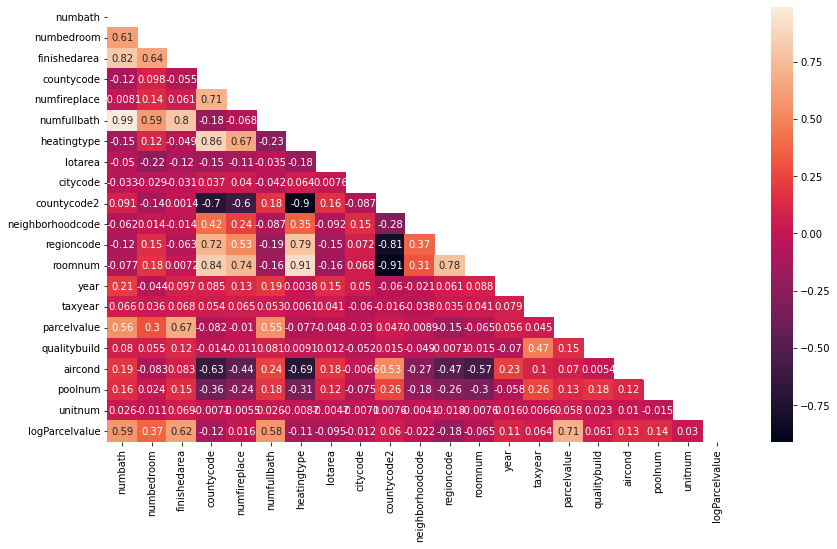

In [ ]:
import seaborn as sns 
# Let's calculate the correlations
df_corr = df_train.corr()

# Plot correlations
# Remove upper triangle
fig, ax = plt.subplots(figsize=(14,8))
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df_corr, mask = mask, annot = True)


#Importing test data

In [ ]:
#loading test data
df_test =  pd.read_csv(path_javier + "test.csv", sep = ";", decimal = ".")
df_test_copy = df_test.loc[:,['lotid','numbath','numbedroom','finishedarea','countycode','numfireplace','numfullbath'
,'heatingtype','latitude','longitude','lotarea','citycode','countycode2','neighborhoodcode','regioncode'
,'roomnum','year','taxyear']]
df_test_copy['parcelvalue'] = 0
df_test_copy["logParcelvalue"] = 0
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lotid             200 non-null    int64  
 1   numbath           200 non-null    float64
 2   numbedroom        200 non-null    int64  
 3   finishedarea      200 non-null    int64  
 4   countycode        200 non-null    int64  
 5   numfireplace      200 non-null    int64  
 6   numfullbath       200 non-null    int64  
 7   heatingtype       132 non-null    float64
 8   latitude          200 non-null    int64  
 9   longitude         200 non-null    int64  
 10  lotarea           197 non-null    float64
 11  citycode          200 non-null    int64  
 12  countycode2       200 non-null    int64  
 13  neighborhoodcode  136 non-null    float64
 14  regioncode        200 non-null    int64  
 15  roomnum           200 non-null    int64  
 16  year              199 non-null    float64
 1

In [ ]:
#formating test data
df_test_copy["qualitybuild"] = df_test["qualitybuild"]
df_test_copy.loc[df_test_copy["qualitybuild"].isna(),"qualitybuild"] = df_test["qualitybuild"].mean()
df_test_copy.loc[df_test_copy["heatingtype"].isna(), "heatingtype"] = 13
df_test_copy["aircond"] = df_test["aircond"]
df_test_copy['aircond'] = df_test_copy['aircond'].fillna(0)

df_test_copy.loc[df_test_copy["lotarea"].isna(),"lotarea"] = df_test["lotarea"].mean()

df_test_copy.loc[df_test_copy["year"].isna(),"year"] = df_test["year"].median()


df_test_copy.aircond = df_test_copy.apply(lambda x: aircond_change(x.aircond), axis=1)
df_test_copy["poolnum"] = df_test["poolnum"]
df_test_copy['poolnum'] = df_test_copy['poolnum'].fillna(0)
df_test_copy["unitnum"] = df_test["unitnum"]
df_test_copy['unitnum'] = df_test_copy['unitnum'].fillna(1)

#df_test_copy = df_test_copy.dropna(how = "any")
df_output = df_test_copy.loc[:,['lotid']]

df_test_copy = df_test_copy.drop(["lotid","latitude","longitude"], axis = 1)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   numbath           200 non-null    float64
 1   numbedroom        200 non-null    int64  
 2   finishedarea      200 non-null    int64  
 3   countycode        200 non-null    int64  
 4   numfireplace      200 non-null    int64  
 5   numfullbath       200 non-null    int64  
 6   heatingtype       200 non-null    float64
 7   lotarea           200 non-null    float64
 8   citycode          200 non-null    int64  
 9   countycode2       200 non-null    int64  
 10  neighborhoodcode  136 non-null    float64
 11  regioncode        200 non-null    int64  
 12  roomnum           200 non-null    int64  
 13  year              200 non-null    float64
 14  taxyear           200 non-null    int64  
 15  parcelvalue       200 non-null    int64  
 16  logParcelvalue    200 non-null    int64  
 1

#Combining and working the data (dummy var creation and standardizing)

---



In [ ]:
#conbine the training table and test table into one
df_comb = pd.concat([df_train,df_test_copy],axis=0,join='inner')
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14982 entries, 0 to 199
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   numbath           14982 non-null  float64
 1   numbedroom        14982 non-null  int64  
 2   finishedarea      14982 non-null  float64
 3   countycode        14982 non-null  int64  
 4   numfireplace      14982 non-null  int64  
 5   numfullbath       14982 non-null  float64
 6   heatingtype       14982 non-null  float64
 7   lotarea           14982 non-null  float64
 8   citycode          14982 non-null  float64
 9   countycode2       14982 non-null  int64  
 10  neighborhoodcode  14918 non-null  float64
 11  regioncode        14982 non-null  float64
 12  roomnum           14982 non-null  int64  
 13  year              14982 non-null  float64
 14  taxyear           14982 non-null  int64  
 15  parcelvalue       14982 non-null  float64
 16  qualitybuild      14982 non-null  float64


In [ ]:
df_comb["finishedarea"] = np.log(df_comb["finishedarea"])

In [ ]:
#creating dummy variables

df_comb = pd.get_dummies(df_comb, columns = ["countycode", "heatingtype", 
                                            "citycode", "regioncode", "neighborhoodcode","qualitybuild"])

In [ ]:
df_comb.head()

,numbath,numbedroom,finishedarea,numfireplace,numfullbath,lotarea,countycode2,roomnum,year,taxyear,...,qualitybuild_5.0,qualitybuild_5.540322580645161,qualitybuild_5.633815759246497,qualitybuild_6.0,qualitybuild_7.0,qualitybuild_8.0,qualitybuild_9.0,qualitybuild_10.0,qualitybuild_11.0,qualitybuild_12.0
0,2.0,3,7.134891,1,2.0,12497.0,2061,6,1979.0,2015,...,0,0,1,0,0,0,0,0,0,0
1,2.0,1,6.940222,0,2.0,20527.0,3101,0,1973.0,2015,...,0,0,0,0,0,0,0,0,0,0
3,2.0,3,7.471363,0,2.0,8612.0,3101,0,1952.0,2015,...,0,0,0,0,1,0,0,0,0,0
4,3.0,2,7.576097,0,3.0,2660.0,2061,6,1988.0,2015,...,0,0,1,0,0,0,0,0,0,0
5,2.0,3,7.403061,1,2.0,4986.0,1286,6,1976.0,2015,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Import library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [ ]:
#standardizing data
from sklearn.preprocessing import StandardScaler

not_standardize_list = ["countycode_", "heatingtype_", "citycode_", "regioncode_","poolnum","aircond", "neighborhoodcode_","qualitybuild_", "parcelvalue", "logParcelvalue"]

#taking out dummy variables
standardize_vars_cols = []
dummy_vars_and_y = []
for column in df_comb.columns:
  for element in not_standardize_list:
   
    if element in column:
      save = False
      break
    else:
      save = True

  if save:
    standardize_vars_cols.append(column)
  else:
    dummy_vars_and_y.append(column)
print(standardize_vars_cols)

# scaler
scaler = StandardScaler().fit(df_comb[standardize_vars_cols])
scaled_features = scaler.transform(df_comb[standardize_vars_cols])
df_scaled = pd.DataFrame(scaled_features, index = df_comb.index, columns = df_comb[standardize_vars_cols].columns)
df_scaled[dummy_vars_and_y] = df_comb[dummy_vars_and_y]
df_scaled.head()

['numbath', 'numbedroom', 'finishedarea', 'numfireplace', 'numfullbath', 'lotarea', 'countycode2', 'roomnum', 'year', 'taxyear', 'unitnum']


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


,numbath,numbedroom,finishedarea,numfireplace,numfullbath,lotarea,countycode2,roomnum,year,taxyear,...,qualitybuild_5.0,qualitybuild_5.540322580645161,qualitybuild_5.633815759246497,qualitybuild_6.0,qualitybuild_7.0,qualitybuild_8.0,qualitybuild_9.0,qualitybuild_10.0,qualitybuild_11.0,qualitybuild_12.0
0,-0.546946,-0.168430,-0.748404,1.953680,-0.495474,-0.277618,-1.262855,1.558178,0.422337,-0.648978,...,0,0,1,0,0,0,0,0,0,0
1,-0.546946,-1.999649,-1.160606,-0.377108,-0.495474,-0.212912,0.516212,-0.516408,0.112643,-0.648978,...,0,0,0,0,0,0,0,0,0,0
3,-0.546946,-0.168430,-0.035937,-0.377108,-0.495474,-0.308924,0.516212,-0.516408,-0.971283,-0.648978,...,0,0,0,0,1,0,0,0,0,0
4,0.394067,-1.084039,0.185834,-0.377108,0.437205,-0.356885,-1.262855,1.558178,0.886877,-0.648978,...,0,0,1,0,0,0,0,0,0,0
5,-0.546946,-0.168430,-0.180564,1.953680,-0.495474,-0.338142,-2.588602,1.558178,0.267490,-0.648978,...,0,0,1,0,0,0,0,0,0,0


#Separating train and test datasets

In [ ]:
#seperate two tables
df_scaled_copy = df_scaled.copy()
df_test_predict = df_scaled_copy[14782:14982]
df_scaled = df_scaled_copy[0:14982]
df_test_predict.drop(["parcelvalue", "logParcelvalue"], inplace = True, axis = 1)
df_test_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Columns: 817 entries, numbath to qualitybuild_12.0
dtypes: float64(12), int64(1), uint8(804)
memory usage: 178.9 KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#Building the model

# Step 4: Build your model and get predictions from train data

In [ ]:
#Create train and test separation inside train data for linear model evaluation
from sklearn.model_selection import train_test_split
SEED = 0

# Arrange data into features and target
features = df_scaled.columns.drop(['parcelvalue', 'logParcelvalue'])

X = df_scaled.loc[:, features]
y =df_scaled.loc[:, 'logParcelvalue']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, train_size = .90)

In [ ]:
# Create model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Create df with all regression information
feature_names = X.columns
model_coefficients = linear_model.coef_

coefficients_df = pd.DataFrame(data = model_coefficients, 
                               index = feature_names, 
                               columns = ['Coefficient value'])
print(coefficients_df)

                   Coefficient value
numbath                 8.951617e-02
numbedroom             -1.750760e-02
finishedarea            3.557996e-01
numfireplace            4.565573e-02
numfullbath            -2.628953e-02
...                              ...
qualitybuild_8.0       -3.338367e+10
qualitybuild_9.0       -3.338367e+10
qualitybuild_10.0      -3.338367e+10
qualitybuild_11.0      -3.338367e+10
qualitybuild_12.0      -3.338367e+10

[817 rows x 1 columns]


In [ ]:
#Evaluate the model (r2_score) on the train
from sklearn.metrics import r2_score 

r2_score_linear = r2_score(y_test,linear_model.predict(X_test))
print("R2 of linear model on train set: {:.2f}".format(r2_score_linear))
print("R2 is smaller than 0, so the distance between the predictions and the \n \
      actual value is bigger than the distance between the actual values and \n \
      their mean. The conclusion is that our model has not learned anything \n \
      from data.")

R2 of linear model on train set: -73928347938574512.00
R2 is smaller than 0, so the distance between the predictions and the 
       actual value is bigger than the distance between the actual values and 
       their mean. The conclusion is that our model has not learned anything 
       from data.


In [ ]:
#cross validation test
from sklearn.model_selection import cross_val_score

scores = cross_val_score(linear_model, X, y, cv=10, scoring = "r2")
print("R2 of linear model on cross validation: {:.2f}".format(np.mean(scores)))

R2 of linear model on cross validation: -3720500493628590592.00


In [ ]:
#RIDGE, alpha optimization SKLEARN RIDGECV IMPLEMENTATION
from sklearn.linear_model import RidgeCV

alphas = np.arange(0.1,2,0.01)

ridge_cross_val_model = RidgeCV(alphas, normalize = False)
ridge_cross_val_model.fit(X,y)
print("Best alpha: {:.2f}".format(ridge_cross_val_model.alpha_))
print("R2 score of cross validation on ridge model with best alpha: {:.2f}".format(ridge_cross_val_model.score(X,y)))
ridge_coefs_df = pd.DataFrame(data = ridge_cross_val_model.coef_,
                   index = feature_names,
                   columns = ["Coefficient value"])
print(ridge_coefs_df.sort_values("Coefficient value"))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


Best alpha: 1.20
R2 score of cross validation on ridge model with best alpha: 0.50
                                Coefficient value
qualitybuild_5.540322580645161         -10.886477
citycode_40227.0                        -6.024284
citycode_22827.0                        -5.325065
regioncode_96268.0                      -5.033173
regioncode_96505.0                      -3.802523
...                                           ...
citycode_12447.0                         2.262959
regioncode_96088.0                       2.452289
neighborhoodcode_762177.0                2.605564
neighborhoodcode_762181.0                3.109901
neighborhoodcode_763680.0                4.776814

[817 rows x 1 columns]


In [ ]:
#LASSO

from sklearn.linear_model import LassoCV

lasso_cross_val = LassoCV(eps = 0.001, n_alphas = 100, normalize = False)
lasso_cross_val.fit(X,y)

print("Best alpha: {:.2f}".format(lasso_cross_val.alpha_))
print("R2 score of cross validation on ridge model with best alpha: {:.2f}".format(lasso_cross_val.score(X,y)))
lasso_coefs_df = pd.DataFrame(data = lasso_cross_val.coef_, 
                          index = feature_names, 
                          columns = ['Coefficient value'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


Best alpha: 0.00
R2 score of cross validation on ridge model with best alpha: 0.46


In [ ]:
print(lasso_coefs_df[lasso_coefs_df["Coefficient value"]>0])

                                Coefficient value
numbath                                  0.113703
numbedroom                               0.009167
finishedarea                             0.272535
numfireplace                             0.065675
year                                     0.020379
...                                           ...
qualitybuild_1.0                         0.098609
qualitybuild_5.633815759246497           0.128303
qualitybuild_9.0                         0.126659
qualitybuild_10.0                        0.276495
qualitybuild_11.0                        0.018924

[64 rows x 1 columns]


In [ ]:
from sklearn.linear_model import ElasticNetCV

elastic_cross_val = ElasticNetCV(normalize = False)
elastic_cross_val.fit(X,y)

print("Best alpha: {:.2f}".format(elastic_cross_val.alpha_))
print("R2 score of cross validation on ridge model with best alpha: {:.2f}".format(elastic_cross_val.score(X,y)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


Best alpha: 0.00
R2 score of cross validation on ridge model with best alpha: 0.44


In [ ]:
elastic_coefs_df = pd.DataFrame(data = elastic_cross_val.coef_, 
                          index = feature_names, 
                          columns = ['Coefficient value'])

In [ ]:
print(lasso_coefs_df[lasso_coefs_df["Coefficient value"]>0])

                                Coefficient value
numbath                                  0.113703
numbedroom                               0.009167
finishedarea                             0.272535
numfireplace                             0.065675
year                                     0.020379
...                                           ...
qualitybuild_1.0                         0.098609
qualitybuild_5.633815759246497           0.128303
qualitybuild_9.0                         0.126659
qualitybuild_10.0                        0.276495
qualitybuild_11.0                        0.018924

[64 rows x 1 columns]


In [ ]:
#predict and export the output
parcelvalue = ridge_cross_val_model.predict(df_test_predict)

df_output['parcelvalue'] = parcelvalue
df_output.to_csv("test_predictions_submit.csv", index = False)

files.download('test_predictions_submit.csv')
df_output.info()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lotid        200 non-null    int64  
 1   parcelvalue  200 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.2 KB


# Report variable impact

Here the most important coefficients for each model are displayed. We can see that more or less they give importance to the same variables, but we see also that ridge model keeps a lot of variables (most of them probably with a very small value but not 0) then lasso keeps only 64 coefs from more than 800, and elastic net keeps only 147. The linear model is not displayed here as it does not punish any coefficient and keeps them all. 

In [ ]:
# Step 6: Report variable impact
print(ridge_coefs_df[ridge_coefs_df["Coefficient value"]>0])
print(lasso_coefs_df[lasso_coefs_df["Coefficient value"]>0])
print(elastic_coefs_df[elastic_coefs_df["Coefficient value"]>0])


                   Coefficient value
numbath                     0.135418
numbedroom                  0.051823
finishedarea                0.226282
numfireplace                0.065071
year                        0.019311
...                              ...
qualitybuild_8.0            0.831872
qualitybuild_9.0            1.188545
qualitybuild_10.0           1.272963
qualitybuild_11.0           1.110156
qualitybuild_12.0           1.048336

[538 rows x 1 columns]
                                Coefficient value
numbath                                  0.113703
numbedroom                               0.009167
finishedarea                             0.272535
numfireplace                             0.065675
year                                     0.020379
...                                           ...
qualitybuild_1.0                         0.098609
qualitybuild_5.633815759246497           0.128303
qualitybuild_9.0                         0.126659
qualitybuild_10.0               

#AUXILIARY CODES

Inputation of neighborhoodcode from latitude and longitude and download of the new datasets

In [ ]:
df_comb = pd.concat([df_train,df_test], axis = 0, join = 'inner')
df_copy_comb = df_comb.copy()

In [ ]:
df_codes_coordinates = df_copy_comb.loc[~df_copy_comb["neighborhoodcode"].isna(),["neighborhoodcode", "latitude", "longitude"]]
df_codes_coordinates = df_codes_coordinates.groupby("neighborhoodcode", as_index = False).agg({"latitude":"mean","longitude":"mean"})
df_codes_coordinates.loc[:,["latitude","longitude"]] = df_codes_coordinates.loc[:,["latitude","longitude"]]/1000000
df_codes_coordinates.columns

Index(['neighborhoodcode', 'latitude', 'longitude'], dtype='object')

In [ ]:
#Fixing Neighborhoodcode calculating distances with latitude and longitude
import geopy.distance #library to calc distance from lat lon points

def fill_neighborhoodcode_distance(lat,lon, df_codes_coordinates, max_dist = 1):
  
  coords_2 = (lat/1000000,lon/1000000)#one single point
  aux_table = df_codes_coordinates.copy()
  aux_table["distance"] = aux_table.apply(lambda x: geopy.distance.geodesic((x.latitude, x.longitude), coords_2).km, axis = 1)
  
  neighborhoodcode = aux_table[aux_table["distance"] == aux_table["distance"].min()]
  if float(neighborhoodcode.iloc[[0]]["distance"]) < max_dist:
    if len(neighborhoodcode) > 1:
      return float(neighborhoodcode.iloc[[0]]["neighborhoodcode"])

    else:
      return float(neighborhoodcode["neighborhoodcode"])
  else:
    return None

df_train["neighborhoodcode"] = df_train.apply(lambda x: fill_neighborhoodcode_distance(x.latitude, x.longitude, df_codes_coordinates)
                      if pd.isnull(x.neighborhoodcode) else x.neighborhoodcode, axis = 1)

df_test["neighborhoodcode"] = df_test.apply(lambda x: fill_neighborhoodcode_distance(x.latitude, x.longitude, df_codes_coordinates)
                      if pd.isnull(x.neighborhoodcode) else x.neighborhoodcode, axis = 1)



In [ ]:
from google.colab import files
df_train.to_csv('train.csv', encoding='utf-8-sig', sep = ";", decimal = ".") 
files.download('train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
df_test.to_csv('test.csv', encoding='utf-8-sig', sep = ";", decimal = ".") 
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>